In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
import os 
# from datetime import datetime
import datetime
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt

from keras import models, layers, optimizers
from keras.layers import Dense, Flatten, AveragePooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from inception_v4_conv_fc import inception_v4

In [3]:
# Set up the GPU to avoid the runtime error: Could not create cuDNN handle...
# -gpus = tf.config.experimental.list_physical_devices('GPU')
# -for gpu in gpus:
    # -tf.config.experimental.set_memory_growth(gpu, True)
    
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# Give the arguments for the conv_base
input_shape = (299,299,3)
num_classes = 1001
weights='imagenet'
include_top = None 

conv_base = inception_v4(input_shape, num_classes, weights, include_top)
conv_base.summary()

Model: "inception_v4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Total params: 41,174,400
Trainable params: 41,111,232
Non-trainable params: 63,168
__________________________________________________________________________________________________


In [5]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D(name='avg_pool'))
model.add(layers.Dropout(0.6))
model.add(layers.Flatten())
model.add(layers.Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v4 (Model)         (None, 8, 8, 1536)        41174400  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3074      
Total params: 41,177,474
Trainable params: 41,114,306
Non-trainable params: 63,168
_________________________________________________________________


In [6]:
# Finetune the last fully connected layers(the inception_c block)
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'inception_c':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Give the directory for train, validation and test sets. 
base_dir = '/home/mic/Documents/keras_inception_v4/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
        
        
# Train the given datasets 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(299, 299),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
# Compile the model with the small optimizer
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [8]:
# Start Tensorboard --logdir logs/fit
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback_list = [tensorboard_callback]

In [9]:
# Train the fintuned model 
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=callback_list)

Epoch 1/30
100/100 [==============================] - 45s 450ms/step - loss: 1.6288 - acc: 0.5345 - val_loss: 1.4773 - val_acc: 0.5410
Epoch 2/30
100/100 [==============================] - 44s 438ms/step - loss: 1.6044 - acc: 0.5150 - val_loss: 1.4703 - val_acc: 0.5060
Epoch 3/30
100/100 [==============================] - 44s 437ms/step - loss: 1.5988 - acc: 0.5135 - val_loss: 1.4659 - val_acc: 0.4790
Epoch 4/30
100/100 [==============================] - 42s 425ms/step - loss: 1.5812 - acc: 0.4890 - val_loss: 1.4624 - val_acc: 0.4990
Epoch 5/30
100/100 [==============================] - 42s 416ms/step - loss: 1.5780 - acc: 0.5115 - val_loss: 1.4580 - val_acc: 0.4900
Epoch 6/30
100/100 [==============================] - 42s 417ms/step - loss: 1.5650 - acc: 0.5140 - val_loss: 1.4572 - val_acc: 0.4630
Epoch 7/30
100/100 [==============================] - 42s 417ms/step - loss: 1.5501 - acc: 0.4955 - val_loss: 1.4539 - val_acc: 0.4740
Epoch 8/30
100/100 [==============================] - 4

In [10]:
# Show the graph
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 5354), started 0:26:19 ago. (Use '!kill 5354' to kill it.)

In [11]:
# Save the trained weights 
model.save('inception_v4_weights_tf_cats_and_dogs_small.h5')

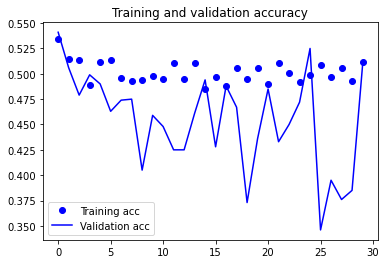

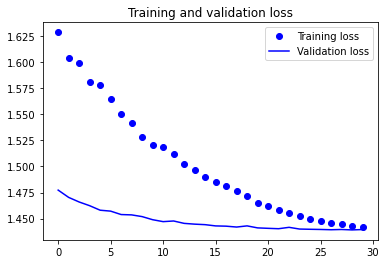

In [12]:
# Draw the genenral curves 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

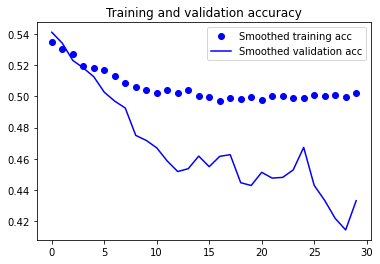

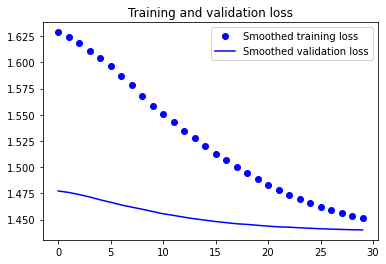

In [13]:
# Define the smooth_curve function  
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plot the smoothed curve 
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
# Evaluate the fine-tuned model on the test data
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(299, 299),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 5s 103ms/step - loss: 1.4395 - acc: 0.4880
test acc: 0.4880000054836273
